In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/dataset.csv')

In [3]:
df = df.drop(columns=['UserID', 'Video ID', 'Location', 'Watch Time', 'CurrentActivity', 'Time Spent On Video'])

df = pd.get_dummies(df, columns=['Gender', 'Platform', 'Profession', 'Demographics', 'Video Category', 'Frequency', 'Watch Reason', 'DeviceType', 'OS', 'ConnectionType'], drop_first=True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Self Control'] = le.fit_transform(df['Self Control'])

relevant_columns = ['Total Time Spent', 'Addiction Level', 'Satisfaction', 'Engagement', 'Self Control', 'ProductivityLoss']
df = df[relevant_columns]

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Total Time Spent  1000 non-null   int64
 1   Addiction Level   1000 non-null   int64
 2   Satisfaction      1000 non-null   int64
 3   Engagement        1000 non-null   int64
 4   Self Control      1000 non-null   int64
 5   ProductivityLoss  1000 non-null   int64
dtypes: int64(6)
memory usage: 47.0 KB
None


In [ ]:
from dowhy import CausalModel
from dataclasses import dataclass
from typing import List, Dict, Tuple

@dataclass
class CausalAnalysisConfig:
    treatment: str
    outcome: str
    common_causes: List[str]
    description: str

def run_causal_analysis(
    df: pd.DataFrame,
    config: CausalAnalysisConfig,
    method: str = "backdoor.linear_regression"
) -> Tuple[float, Dict]:
    model = CausalModel(
        data=df,
        treatment=config.treatment,
        outcome=config.outcome,
        common_causes=config.common_causes
    )
    
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name=method
    )
    
    return causal_estimate

def main(df: pd.DataFrame) -> Dict[str, float]:

    analyses = [
        CausalAnalysisConfig(
            treatment="Addiction Level",
            outcome="Satisfaction",
            common_causes=["Engagement", "Self Control", "ProductivityLoss"],
            description="Addiction Level → Satisfaction"
        ),
        CausalAnalysisConfig(
            treatment="Addiction Level",
            outcome="Self Control",
            common_causes=["Engagement", "Total Time Spent"],
            description="Addiction Level → Self Control"
        ),
        CausalAnalysisConfig(
            treatment="Engagement",
            outcome="Satisfaction",
            common_causes=["Addiction Level", "Self Control"],
            description="Engagement → Satisfaction"
        ),
        CausalAnalysisConfig(
            treatment="Addiction Level",
            outcome="ProductivityLoss",
            common_causes=["Satisfaction", "Self Control"],
            description="Addiction Level → Productivity Loss"
        )
    ]
    
    # Run all analyses and collect results
    results = {}
    for config in analyses:
        estimate = run_causal_analysis(df, config)
        results[config.description] = estimate
        print(f"Causal Estimate for {config.description}:", estimate)
    
    return results

if __name__ == "__main__":
    results = main(df)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
Causal Estimate for Addiction Level → Satisfaction: *** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                   
──────────────────(E[Satisfaction|Self Control,ProductivityLoss,Engagement])
d[Addiction Level]                                                          
Estimand assumption 1, Unconfoundedness: If U→{Addiction Level} and U→Satisfaction then P(Satisfaction|Addiction Level,Self Control,ProductivityLoss,Engagement,U) = P(Satisfaction|Addiction Level,Self Control,ProductivityLoss,Engagement)

## Realized estimand
b: Satisfaction~Addiction Level+Self Control+ProductivityLoss+Engagement
Target units: ate

## Estimate
Mean val

/home/jagapathi-vallapuri/Desktop/Projects/ADAProject/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/jagapathi-vallapuri/Desktop/Projects/ADAProject/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/jagapathi-vallapuri/Desktop/Projects/ADAProject/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treatin

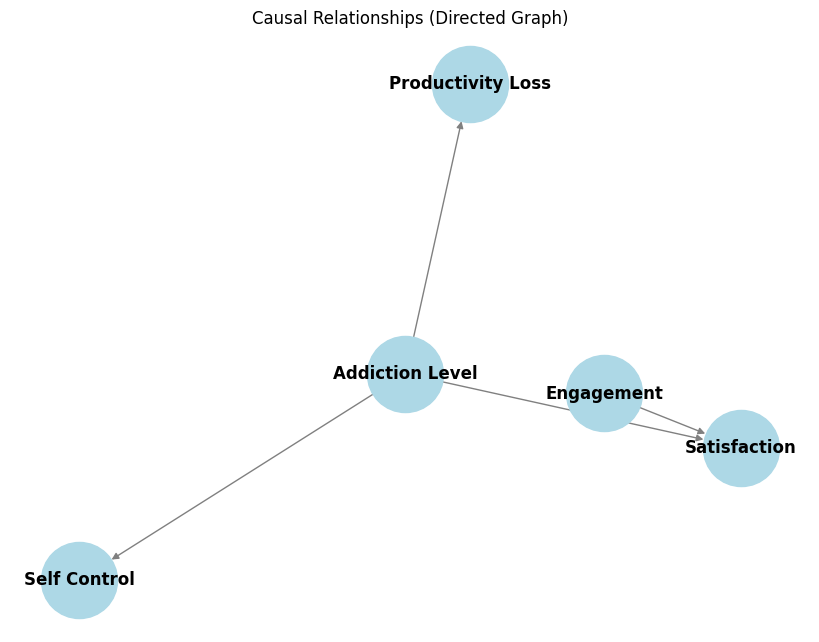

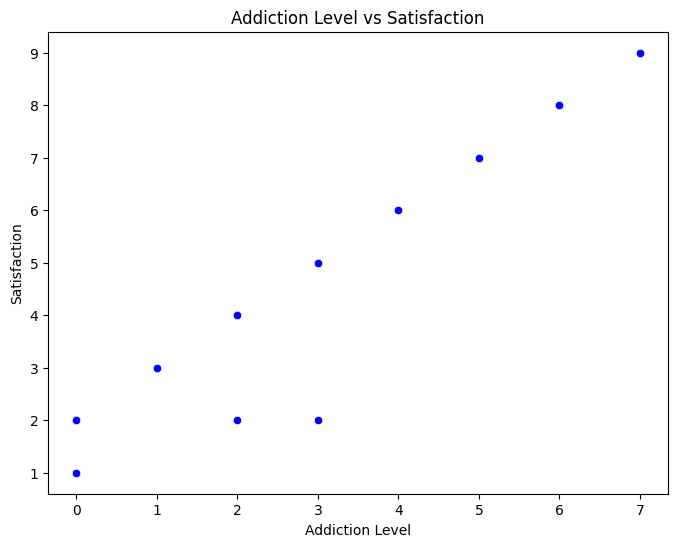

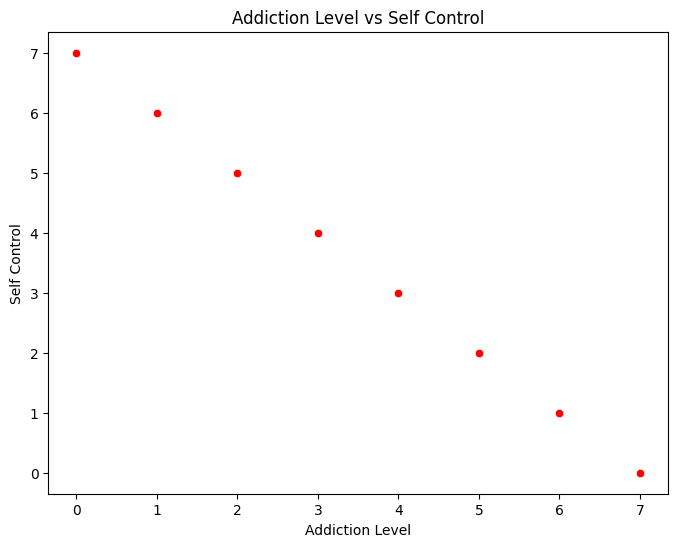

/tmp/ipykernel_7723/754028607.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Effect', y='Estimate', data=estimates_df, palette='viridis')


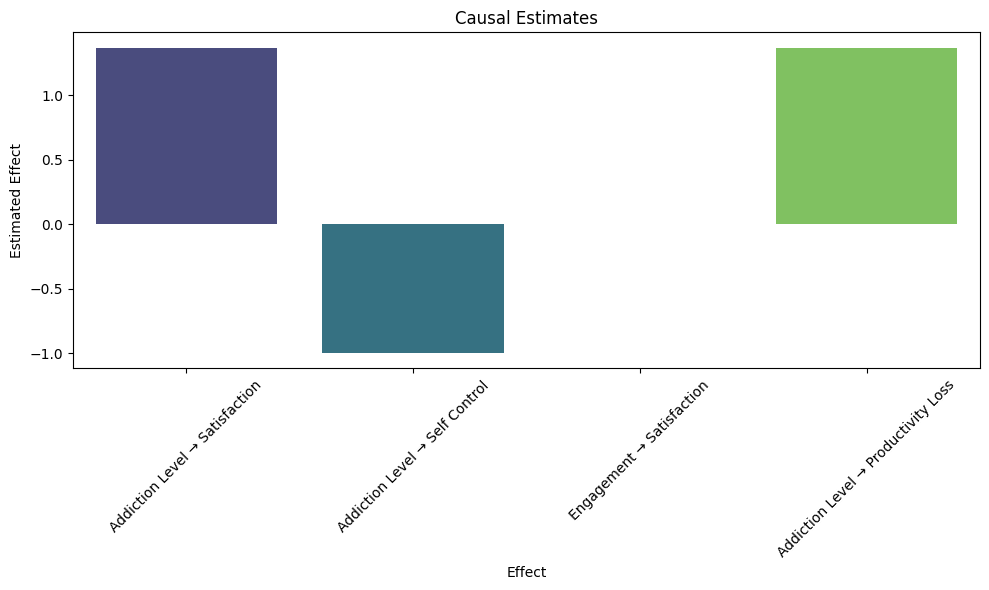

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from dataclasses import dataclass
from typing import List, Dict, Tuple
import numpy as np

@dataclass
class CausalEffect:
    """Data class to store causal effect information"""
    source: str
    target: str
    estimate: float

    @property
    def label(self) -> str:
        return f"{self.source} → {self.target}"

class CausalAnalysis:
    
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.causal_effects = [
            CausalEffect("Addiction Level", "Satisfaction", 1.37),
            CausalEffect("Addiction Level", "Self Control", -1.00),
            CausalEffect("Engagement", "Satisfaction", -1.77e-06),
            CausalEffect("Addiction Level", "Productivity Loss", 1.37)
        ]
        self.graph = self._create_graph()

    def _create_graph(self) -> nx.DiGraph:
        """Create a directed graph from causal effects"""
        G = nx.DiGraph()
        for effect in self.causal_effects:
            G.add_edge(effect.source, effect.target)
        return G

    def plot_causal_graph(self, figsize: Tuple[int, int]=(8, 6)) -> None:
        plt.figure(figsize=figsize)
        pos = nx.spring_layout(self.graph, seed=42)
        nx.draw(
            self.graph, 
            pos, 
            with_labels=True,
            node_color='lightblue',
            node_size=3000,
            font_size=12,
            font_weight='bold',
            edge_color='gray'
        )
        plt.title("Causal Relationships (Directed Graph)")
        plt.show()

    def plot_relationship_scatter(
        self,
        x: str,
        y: str,
        color: str,
        figsize: Tuple[int, int]=(8, 6)
    ) -> None:
        plt.figure(figsize=figsize)
        sns.scatterplot(data=self.data, x=x, y=y, color=color)
        plt.title(f'{x} vs {y}')
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()

    def plot_causal_estimates(self, figsize: Tuple[int, int]=(10, 6)) -> None:
        estimates_data = {
            'Effect': [effect.label for effect in self.causal_effects],
            'Estimate': [effect.estimate for effect in self.causal_effects]
        }
        estimates_df = pd.DataFrame(estimates_data)

        plt.figure(figsize=figsize)
        sns.barplot(x='Effect', y='Estimate', data=estimates_df, palette='viridis')
        plt.title('Causal Estimates')
        plt.ylabel('Estimated Effect')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



def main():
    
    analysis = CausalAnalysis(df)
    
    analysis.plot_causal_graph()
    
    analysis.plot_relationship_scatter(
        'Addiction Level', 
        'Satisfaction', 
        'blue'
    )
    analysis.plot_relationship_scatter(
        'Addiction Level', 
        'Self Control', 
        'red'
    )
    
    analysis.plot_causal_estimates()

if __name__ == "__main__":
    main()

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats

def run_comprehensive_analysis(df):
    """
    Performs comprehensive statistical analysis on social media usage data.
    """
    results = {}
    
    # Main regression model
    y = df['Satisfaction']
    X = df[['Addiction Level', 'Self Control', 'Engagement', 'Total Time Spent']]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    results['main_model'] = model
    
    # Hypothesis testing function
    def hypothesis_testing(model):
        hypothesis_results = {}
        for variable in model.pvalues.index:
            p_value = model.pvalues[variable]
            significance = p_value < 0.05
            hypothesis_results[variable] = {
                'p_value': p_value,
                'significant': significance
            }
        return hypothesis_results
    
    results['hypothesis_tests'] = hypothesis_testing(model)
    
    # Confidence intervals
    results['confidence_intervals'] = model.conf_int(alpha=0.05)
    
    # Bootstrap analysis
    def bootstrap_regression(df, n_iterations=1000):
        coefs = []
        for _ in range(n_iterations):
            sample = df.sample(n=len(df), replace=True)
            X_sample = sample[['Addiction Level', 'Self Control', 'Engagement', 'Total Time Spent']]
            y_sample = sample['Satisfaction']
            X_sample = sm.add_constant(X_sample)
            model_sample = sm.OLS(y_sample, X_sample).fit()
            coefs.append(model_sample.params)
        return pd.DataFrame(coefs)
    
    bootstrap_results = bootstrap_regression(df)
    results['bootstrap_intervals'] = bootstrap_results.quantile([0.025, 0.975])
    
    # Individual relationship analyses
    # Engagement vs Satisfaction
    engagement_model = sm.OLS(
        df['Satisfaction'], 
        sm.add_constant(df['Engagement'])
    ).fit()
    results['engagement_satisfaction_model'] = engagement_model
    
    # Addiction Level vs Self Control (with controls)
    addiction_self_control_model = sm.OLS(
        df['Self Control'], 
        sm.add_constant(df[['Addiction Level', 'Total Time Spent', 'Engagement']])
    ).fit()
    results['addiction_self_control_model'] = addiction_self_control_model
    
    # Calculate causal estimates
    results['causal_estimates'] = {
        'addiction_satisfaction': model.params['Addiction Level'],
        'addiction_self_control': addiction_self_control_model.params['Addiction Level']
    }
    
    def generate_summary_report(results):
        """Generate a formatted summary of all analysis results"""
        report = []
        
        # Main model summary
        report.append("=== Main Model Results ===")
        report.append(str(results['main_model'].summary()))
        
        # Hypothesis test results
        report.append("\n=== Hypothesis Tests ===")
        for var, res in results['hypothesis_tests'].items():
            significance = "significant" if res['significant'] else "not significant"
            report.append(f"{var}: {significance} (p-value: {res['p_value']:.4f})")
        
        # Confidence intervals
        report.append("\n=== 95% Confidence Intervals ===")
        report.append(str(results['confidence_intervals']))
        
        # Bootstrap results
        report.append("\n=== Bootstrap Confidence Intervals ===")
        report.append(str(results['bootstrap_intervals']))
        
        # Causal estimates
        report.append("\n=== Causal Estimates ===")
        for relationship, estimate in results['causal_estimates'].items():
            report.append(f"{relationship}: {estimate:.4f}")
        
        return "\n".join(report)
    
    results['summary_report'] = generate_summary_report(results)
    
    return results

results = run_comprehensive_analysis(df)
print(results['summary_report'])

=== Main Model Results ===
                            OLS Regression Results                            
Dep. Variable:           Satisfaction   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.258e+04
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        08:59:11   Log-Likelihood:                 127.36
No. Observations:                1000   AIC:                            -246.7
Df Residuals:                     996   BIC:                            -227.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const        